# Training on 1kb 5kb Resolution with window size optimization

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from xgboost import plot_importance
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
#from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from numpy import sort

In [2]:
def optimalparamsearch(com):
    com['distance'] =com['distance'].abs()
    com=com.sort_values('pair19')
    com=com.reset_index(drop=True)
    ''' function to do parameter search '''
    cv_names=com["CV"].unique()
    myCViterator = []
    for i in range(len(cv_names)):
        trainIndices = com[ com['CV']!=cv_names[i] ].index.values.astype(int)
        testIndices =  com[ com['CV']==cv_names[i] ].index.values.astype(int)
        myCViterator.append( (trainIndices, testIndices) )


    #run randomized search for optimal parameters

    X_train= com.drop(['gene_id1','gene_id','symbol38','symbol19','pair','pair19','label','CV'], axis=1).copy()
    y_train = com['label'].copy()
    model = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0)
    param_grid = {
            'max_depth': [4, 5, 6,8,10,12],
            'learning_rate': [0.1, 0.05, 0.01],
            'gamma': [0, 0.25, 1.0],
            'reg_lambda': [0, 1.0, 10.0],
            'n_estimators': [100,200,300,400,500],
            'colsample_bytree': [0.5,0.6,0.7,0.9],
            'subsample': [0.7, 0.9]
        }
    search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,scoring='f1', cv=myCViterator, n_jobs=12, refit=True)
    result = search.fit(X_train, y_train)
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    return(result.best_score_, result.best_params_)

In [3]:
def trainOptParams(com, best_params, pathtomodel):
    X_train_xg= com.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
    y_train_xg = com['label'].copy()
    clf_xgb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params)
    clf_xgb.fit(X_train_xg, y_train_xg)
    clf_xgb.save_model(pathtomodel)
    return(clf_xgb)

In [4]:
def makeFeatImpPlot(clf_xgb, sample, pathtopic):
    clf_xgb.get_booster().feature_names= ["CRUP-EP enhancer 1", "CRUP-EP enhancer 2", "CRUP-EP enhancer 3", "CRUP-EP enhancer 4",
                                     "CRUP-EP enhancer 5","CRUP-EP promoter 1","CRUP-EP promoter 2","CRUP-EP promoter 3",
                                     "CRUP-EP promoter 4","CRUP-EP promoter 5","CRUP-PP enhancer 1", "CRUP-PP enhancer 2", 
                                      "CRUP-PP enhancer 3", "CRUP-PP enhancer 4",
                                     "CRUP-PP enhancer 5","CRUP-PP promoter 1","CRUP-PP promoter 2","CRUP-PP promoter 3",
                                     "CRUP-PP promoter 4","CRUP-PP promoter 5","Genomic distance","CRUP correlation",
                                     "Wilcoxon tests combined","Regulatory distance\n enhancers",
                                      "Normalized Regulatory\n distance enhancers","Regulatory distance\n promoters",
                                      "Normalized Regulatory\n distance promoters", "RNA-seq", "Minimum Insulation", "Mean Switch Intensity"]

    fig1=plot_importance(clf_xgb,xlabel="number of times a feature appears in a tree",show_values=False,
                         title= "Feature importance CENTRE.MI.MSI " + sample,ylabel=None,max_num_features=10)
    pyplot.show()
    fig1.figure.tight_layout()
    fig1.figure.savefig(pathtopic, 
                 dpi=300,orientation='landscape',format='png',facecolor='white')
    return(0)

In [5]:
def CVF1results(com, best_params):

    cv_names=com["CV"].unique()
    d = dict(tuple(com.groupby('CV')))
    result_all_xgboost={}
    result_all_tf={}
    result_cv_xg=[]
    result_cv_tf=[]
    for i in range(len(cv_names)):
        cv_test=cv_names[i]
        cv_train=[x for k,x in enumerate(cv_names) if k!=i]
        X_test_xg = d[cv_test].drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_test_xg = d[cv_test]['label'].copy()
        train_xg=pd.concat({k: d[k] for k in cv_train})
        X_train_xg= train_xg.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_train_xg = train_xg['label'].copy()
        clf_xgb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params)
        clf_xgb.fit(X_train_xg, y_train_xg)
        pred_s = clf_xgb.predict_proba(X_test_xg)
        lr_probs =pred_s[:, 1]
        yhat = clf_xgb.predict(X_test_xg)
        result_cv = pd.DataFrame({'pred_prob':lr_probs,'pred_label': yhat,'true_label':y_test_xg})
        result_cv_xg.append(f1_score(result_cv['true_label'], result_cv['pred_label']))
        result_all_xgboost[cv_test]=result_cv
        



    results_xg=pd.concat(result_all_xgboost)
    
    lr_precision_xg, lr_recall_xg, _ = precision_recall_curve(results_xg['true_label'], results_xg['pred_prob'])
    lr_f1_xg, lr_auc_xg = f1_score(results_xg['true_label'], results_xg['pred_label']), auc(lr_recall_xg, lr_precision_xg)
    print('xgboost HiC 12 fold CV:auc=%.3f' % lr_auc_xg)
    print(lr_f1_xg)
    print(result_cv_xg)

    dist_precision, dist_recall, _=precision_recall_curve(com['label'],1/abs(com['distance']))
    dist_auc = auc(dist_recall, dist_precision)
    print('Distance:auc=%.3f' % (dist_auc))
    ##1st f1 scores of CENTRE.MSI.MI
    ##2nd f1 scores of CENTRE
    return(lr_f1_xg, result_cv_xg)

In [6]:
### This is where the script starts

##General paths and suffixes
suffixMIMSI = "-Benchmark.MI.MSI.v38.5kb"
suffixBENGI = "-Benchmark.v38.txt"
rootMIMSI = "/project/CRUP_scores/CENTRE_HiC/Training/BENGI_MSI_MI_datasets/"
rootBENGI = "/project/CRUP_scores/toSara/BENGI_processed_datasets/"

(27079, 38)
est=0.118, cfg={'subsample': 0.9, 'reg_lambda': 1.0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:04:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


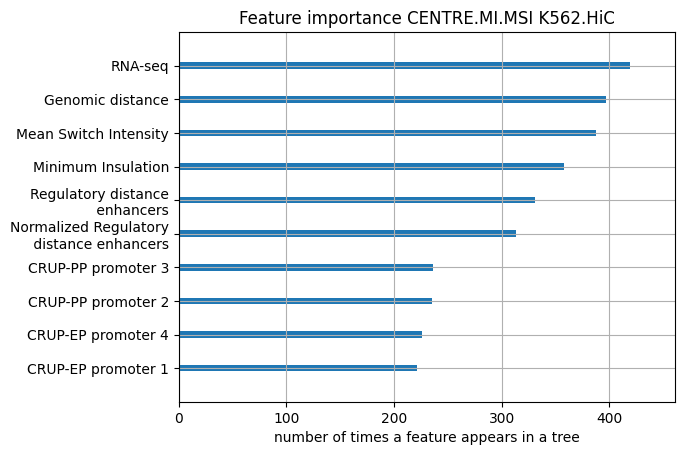


KeyboardInterrupt



In [17]:
window_sizes = ["15kb", "25kb", "35kb", "50kb", "75kb"]
sample = "K562.HiC"
f1data = pd.DataFrame()

for size in window_sizes:
    #GM12878.CHiC

    centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI+size+".csv", 
                     header=0, sep=',')
    print (centreMSIMI.shape)
       
    ##Parameter search
    com=centreMSIMI.fillna(0)
    
    best_score, best_params = optimalparamsearch(com)

    
    ##Train with opt parameters and feature importance
    centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"5kb"+size+"_model.txt")
    makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"5kb"+size+".png")
    
    ##CV
    
    f1_CENTREMIMSI, f1_CENTREMIMSICV = CVF1results(com, best_params)
    f1data2 = pd.DataFrame()                                  
    f1data2['SampleName'] = [sample]*12
    f1data2['WindowSize'] = [size]*12
    f1data2['Resolution'] = ["5kb"]*12
    f1data2['f1'] = f1_CENTREMIMSICV
    f1data = pd.concat([f1data, f1data2], ignore_index = True)
    print(f1data)

In [27]:
f1data.to_csv('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/f1_K562.HiC_5Kb.csv')

(25564, 38)
est=0.399, cfg={'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:14:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


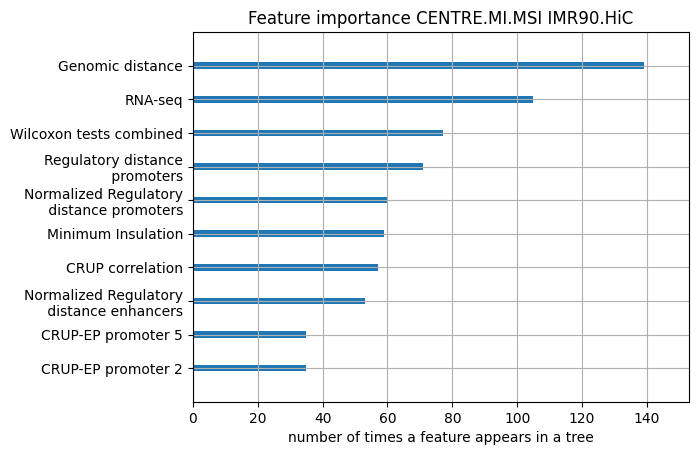

xgboost HiC 12 fold CV:auc=0.361
0.39598701681912063
[0.2990033222591363, 0.49206349206349204, 0.3277591973244147, 0.3525423728813559, 0.4530744336569579, 0.3564356435643565, 0.42585551330798477, 0.4074074074074074, 0.4069264069264069, 0.4189189189189189, 0.40853658536585363, 0.4297520661157025]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.033149
1    K562.HiC       15kb        5kb  0.025641
2    K562.HiC       15kb        5kb  0.162162
3    K562.HiC       15kb        5kb  0.096000
4    K562.HiC       15kb        5kb  0.056738
..        ...        ...        ...       ...
67  IMR90.HiC       15kb        5kb  0.407407
68  IMR90.HiC       15kb        5kb  0.406926
69  IMR90.HiC       15kb        5kb  0.418919
70  IMR90.HiC       15kb        5kb  0.408537
71  IMR90.HiC       15kb        5kb  0.429752

[72 rows x 4 columns]
(25564, 38)
est=0.400, cfg={'subsample': 0.7, 'reg_lambda': 0, 'n_estimators': 200, 'max_depth': 4, 'learning

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:16:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


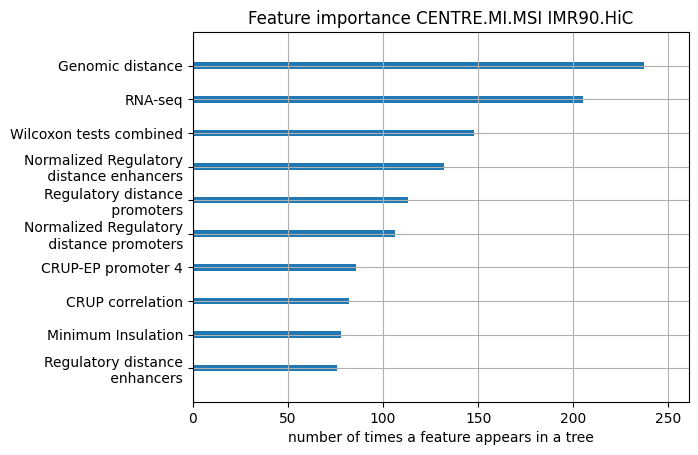

xgboost HiC 12 fold CV:auc=0.357
0.39832033593281346
[0.29605263157894735, 0.4202334630350194, 0.3460207612456747, 0.35211267605633806, 0.4816053511705686, 0.3385579937304075, 0.4338235294117647, 0.3952569169960474, 0.4298245614035088, 0.4391891891891892, 0.43137254901960786, 0.44052863436123346]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.033149
1    K562.HiC       15kb        5kb  0.025641
2    K562.HiC       15kb        5kb  0.162162
3    K562.HiC       15kb        5kb  0.096000
4    K562.HiC       15kb        5kb  0.056738
..        ...        ...        ...       ...
79  IMR90.HiC       25kb        5kb  0.395257
80  IMR90.HiC       25kb        5kb  0.429825
81  IMR90.HiC       25kb        5kb  0.439189
82  IMR90.HiC       25kb        5kb  0.431373
83  IMR90.HiC       25kb        5kb  0.440529

[84 rows x 4 columns]
(25564, 38)
est=0.400, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_estimators': 300, 'max_depth': 4, 'lear

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:19:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


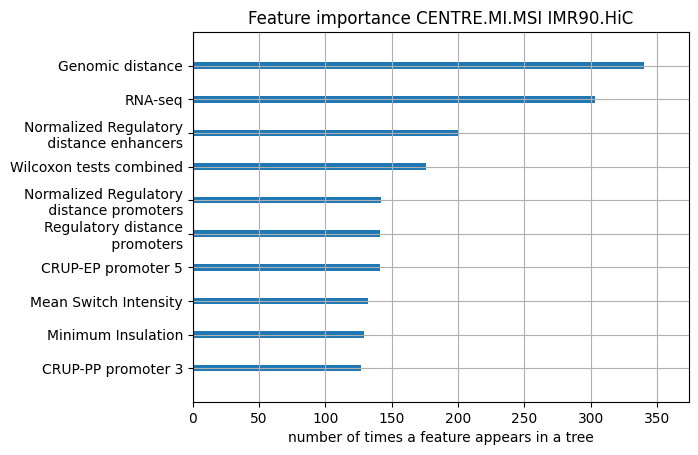

xgboost HiC 12 fold CV:auc=0.364
0.3967911138537489
[0.27007299270072993, 0.4302788844621514, 0.352059925093633, 0.3680555555555555, 0.46308724832214765, 0.34234234234234234, 0.42023346303501946, 0.4194756554307116, 0.4000000000000001, 0.4532374100719424, 0.4, 0.4678899082568807]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.033149
1    K562.HiC       15kb        5kb  0.025641
2    K562.HiC       15kb        5kb  0.162162
3    K562.HiC       15kb        5kb  0.096000
4    K562.HiC       15kb        5kb  0.056738
..        ...        ...        ...       ...
91  IMR90.HiC       35kb        5kb  0.419476
92  IMR90.HiC       35kb        5kb  0.400000
93  IMR90.HiC       35kb        5kb  0.453237
94  IMR90.HiC       35kb        5kb  0.400000
95  IMR90.HiC       35kb        5kb  0.467890

[96 rows x 4 columns]
(25564, 38)
est=0.407, cfg={'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:23:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


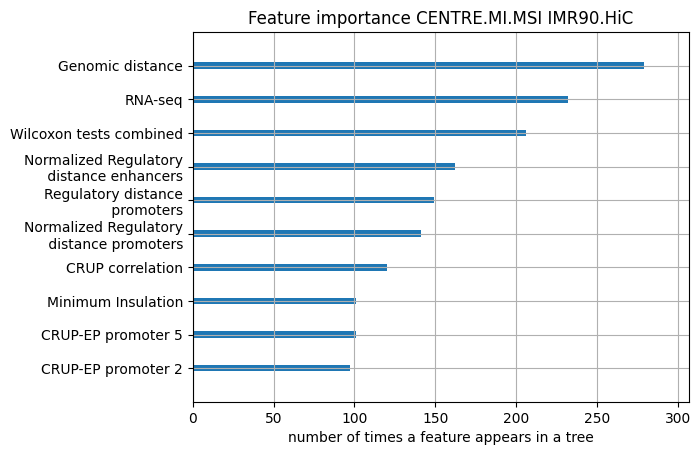

xgboost HiC 12 fold CV:auc=0.357
0.3968
[0.31818181818181823, 0.49122807017543857, 0.3622047244094488, 0.3655172413793103, 0.44745762711864406, 0.35335689045936397, 0.3937007874015748, 0.4250000000000001, 0.36448598130841126, 0.40425531914893614, 0.38688524590163936, 0.4722222222222222]
Distance:auc=0.073
    SampleName WindowSize Resolution        f1
0     K562.HiC       15kb        5kb  0.033149
1     K562.HiC       15kb        5kb  0.025641
2     K562.HiC       15kb        5kb  0.162162
3     K562.HiC       15kb        5kb  0.096000
4     K562.HiC       15kb        5kb  0.056738
..         ...        ...        ...       ...
103  IMR90.HiC       50kb        5kb  0.425000
104  IMR90.HiC       50kb        5kb  0.364486
105  IMR90.HiC       50kb        5kb  0.404255
106  IMR90.HiC       50kb        5kb  0.386885
107  IMR90.HiC       50kb        5kb  0.472222

[108 rows x 4 columns]
(25564, 38)
est=0.402, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_estimators': 300, 'max_depth': 5, 'l

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:25:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


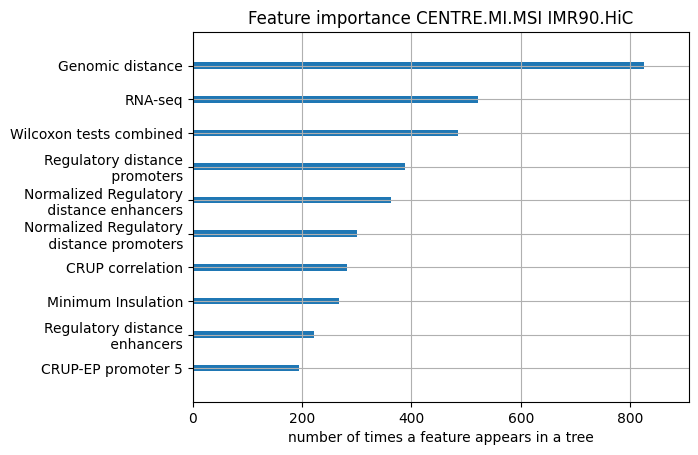

xgboost HiC 12 fold CV:auc=0.356
0.39215686274509803
[0.2918149466192171, 0.48101265822784806, 0.3321554770318021, 0.35125448028673834, 0.42953020134228187, 0.3368421052631579, 0.42105263157894735, 0.45161290322580644, 0.3714285714285714, 0.41843971631205673, 0.3946488294314382, 0.46009389671361506]
Distance:auc=0.073
    SampleName WindowSize Resolution        f1
0     K562.HiC       15kb        5kb  0.033149
1     K562.HiC       15kb        5kb  0.025641
2     K562.HiC       15kb        5kb  0.162162
3     K562.HiC       15kb        5kb  0.096000
4     K562.HiC       15kb        5kb  0.056738
..         ...        ...        ...       ...
115  IMR90.HiC       75kb        5kb  0.451613
116  IMR90.HiC       75kb        5kb  0.371429
117  IMR90.HiC       75kb        5kb  0.418440
118  IMR90.HiC       75kb        5kb  0.394649
119  IMR90.HiC       75kb        5kb  0.460094

[120 rows x 4 columns]


In [28]:
## IMR-90 HiC
## window sizes vector
window_sizes = ["15kb", "25kb", "35kb", "50kb", "75kb"]
sample = "IMR90.HiC"


for size in window_sizes:
    #GM12878.CHiC

    centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI+size+".csv", 
                     header=0, sep=',')
    print (centreMSIMI.shape)
       
    ##Parameter search
    com=centreMSIMI.fillna(0)
    
    best_score, best_params = optimalparamsearch(com)

    
    ##Train with opt parameters and feature importance
    centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"5kb"+size+"_model.txt")
    makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"5kb"+size+".png")
    
    ##CV
    
    f1_CENTREMIMSI, f1_CENTREMIMSICV = CVF1results(com, best_params)
    f1data2 = pd.DataFrame()                                  
    f1data2['SampleName'] = [sample]*12
    f1data2['WindowSize'] = [size]*12
    f1data2['Resolution'] = ["5kb"]*12
    f1data2['f1'] = f1_CENTREMIMSICV
    f1data = pd.concat([f1data, f1data2], ignore_index = True)
    print(f1data)

In [29]:
f1data.to_csv('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/f1_K562.HiCandIMR90_5Kb.csv')

In [9]:
##Next day continue where we left of. We want to collect f1 scores in one file so we reload f1data as to not recompute any of the time
## intesive cells

f1path = '/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/f1_K562.HiCandIMR90_5Kb.csv'
f1data = pd.read_csv(f1path, header=0, sep=',', index_col = 0)
print(f1data)

    SampleName WindowSize Resolution        f1
0     K562.HiC       15kb        5kb  0.033149
1     K562.HiC       15kb        5kb  0.025641
2     K562.HiC       15kb        5kb  0.162162
3     K562.HiC       15kb        5kb  0.096000
4     K562.HiC       15kb        5kb  0.056738
..         ...        ...        ...       ...
115  IMR90.HiC       75kb        5kb  0.451613
116  IMR90.HiC       75kb        5kb  0.371429
117  IMR90.HiC       75kb        5kb  0.418440
118  IMR90.HiC       75kb        5kb  0.394649
119  IMR90.HiC       75kb        5kb  0.460094

[120 rows x 4 columns]


(13961, 38)
est=0.551, cfg={'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:15:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


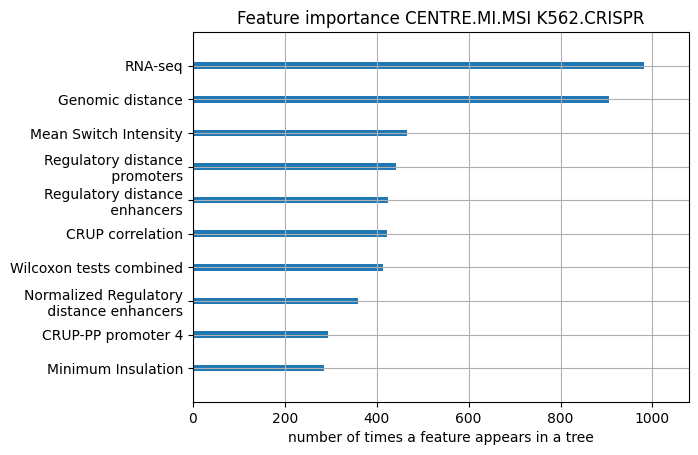

xgboost HiC 12 fold CV:auc=0.546
0.5401709401709401
[0.5892857142857142, 0.6666666666666666, 0.4044943820224719, 0.44186046511627913, 0.3503649635036496, 0.6923076923076923, 0.49504950495049505, 0.39285714285714285, 0.5974025974025974, 0.6521739130434783, 0.6428571428571429, 0.6782608695652174]
Distance:auc=0.252
      SampleName WindowSize Resolution        f1
0       K562.HiC       15kb        5kb  0.033149
1       K562.HiC       15kb        5kb  0.025641
2       K562.HiC       15kb        5kb  0.162162
3       K562.HiC       15kb        5kb  0.096000
4       K562.HiC       15kb        5kb  0.056738
..           ...        ...        ...       ...
127  K562.CRISPR       15kb        5kb  0.392857
128  K562.CRISPR       15kb        5kb  0.597403
129  K562.CRISPR       15kb        5kb  0.652174
130  K562.CRISPR       15kb        5kb  0.642857
131  K562.CRISPR       15kb        5kb  0.678261

[132 rows x 4 columns]
(13961, 38)
est=0.543, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_esti

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:17:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


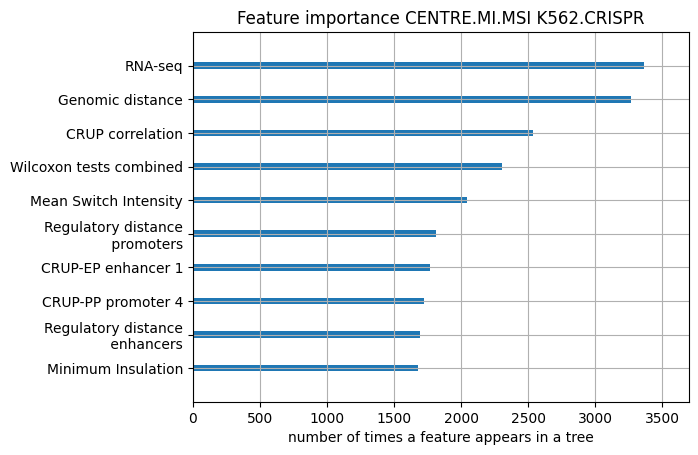

xgboost HiC 12 fold CV:auc=0.542
0.5442043222003929
[0.588235294117647, 0.6097560975609756, 0.3544303797468355, 0.3783783783783784, 0.4081632653061224, 0.6301369863013699, 0.5555555555555556, 0.43750000000000006, 0.6176470588235295, 0.6233766233766234, 0.647887323943662, 0.6851851851851852]
Distance:auc=0.252
      SampleName WindowSize Resolution        f1
0       K562.HiC       15kb        5kb  0.033149
1       K562.HiC       15kb        5kb  0.025641
2       K562.HiC       15kb        5kb  0.162162
3       K562.HiC       15kb        5kb  0.096000
4       K562.HiC       15kb        5kb  0.056738
..           ...        ...        ...       ...
139  K562.CRISPR       25kb        5kb  0.437500
140  K562.CRISPR       25kb        5kb  0.617647
141  K562.CRISPR       25kb        5kb  0.623377
142  K562.CRISPR       25kb        5kb  0.647887
143  K562.CRISPR       25kb        5kb  0.685185

[144 rows x 4 columns]
(13961, 38)
est=0.546, cfg={'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimator

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:20:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


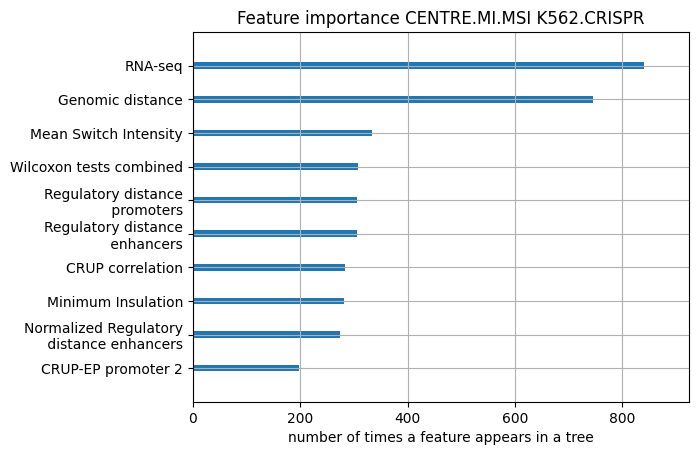

xgboost HiC 12 fold CV:auc=0.554
0.5344
[0.5826771653543307, 0.6451612903225806, 0.3917525773195877, 0.4175824175824176, 0.3511450381679389, 0.7073170731707317, 0.45871559633027525, 0.4233576642335767, 0.5974025974025974, 0.6947368421052632, 0.6444444444444446, 0.628099173553719]
Distance:auc=0.252
      SampleName WindowSize Resolution        f1
0       K562.HiC       15kb        5kb  0.033149
1       K562.HiC       15kb        5kb  0.025641
2       K562.HiC       15kb        5kb  0.162162
3       K562.HiC       15kb        5kb  0.096000
4       K562.HiC       15kb        5kb  0.056738
..           ...        ...        ...       ...
151  K562.CRISPR       35kb        5kb  0.423358
152  K562.CRISPR       35kb        5kb  0.597403
153  K562.CRISPR       35kb        5kb  0.694737
154  K562.CRISPR       35kb        5kb  0.644444
155  K562.CRISPR       35kb        5kb  0.628099

[156 rows x 4 columns]
(13961, 38)
est=0.527, cfg={'subsample': 0.7, 'reg_lambda': 1.0, 'n_estimators': 200, 'm

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:21:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


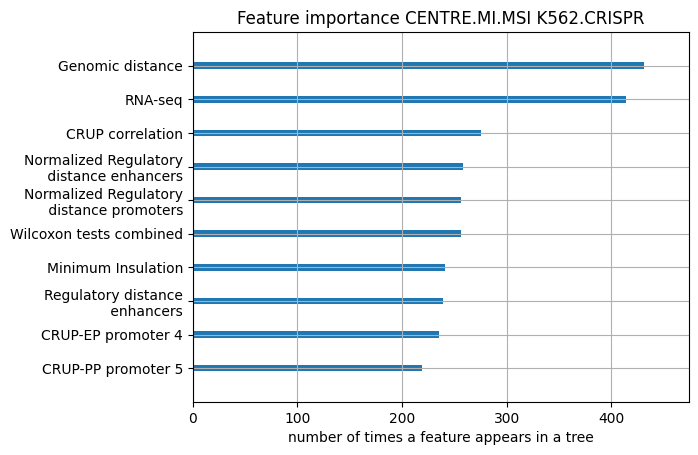

xgboost HiC 12 fold CV:auc=0.515
0.5364891518737672
[0.5510204081632653, 0.6578947368421053, 0.40476190476190477, 0.41025641025641024, 0.3673469387755102, 0.684931506849315, 0.4565217391304348, 0.4444444444444445, 0.48571428571428565, 0.7000000000000001, 0.6285714285714287, 0.6857142857142857]
Distance:auc=0.252
      SampleName WindowSize Resolution        f1
0       K562.HiC       15kb        5kb  0.033149
1       K562.HiC       15kb        5kb  0.025641
2       K562.HiC       15kb        5kb  0.162162
3       K562.HiC       15kb        5kb  0.096000
4       K562.HiC       15kb        5kb  0.056738
..           ...        ...        ...       ...
163  K562.CRISPR       50kb        5kb  0.444444
164  K562.CRISPR       50kb        5kb  0.485714
165  K562.CRISPR       50kb        5kb  0.700000
166  K562.CRISPR       50kb        5kb  0.628571
167  K562.CRISPR       50kb        5kb  0.685714

[168 rows x 4 columns]
(13961, 38)
est=0.550, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_estim

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:22:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


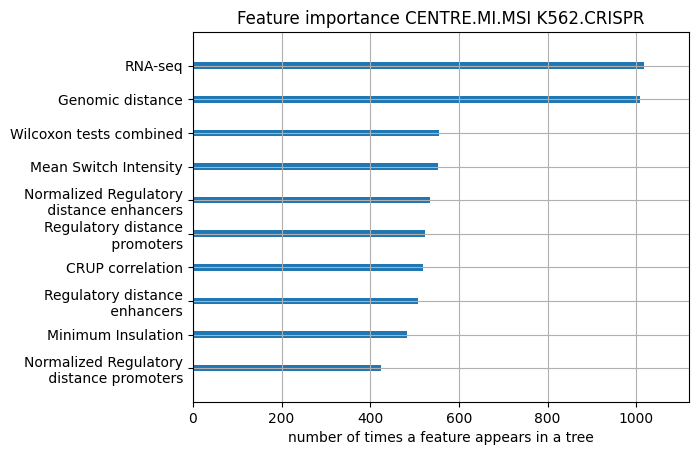

xgboost HiC 12 fold CV:auc=0.536
0.5424892703862662
[0.5789473684210527, 0.6428571428571429, 0.4123711340206186, 0.4186046511627907, 0.39316239316239315, 0.7341772151898733, 0.4854368932038835, 0.40650406504065045, 0.5974025974025974, 0.6666666666666666, 0.6419753086419753, 0.6495726495726495]
Distance:auc=0.252
      SampleName WindowSize Resolution        f1
0       K562.HiC       15kb        5kb  0.033149
1       K562.HiC       15kb        5kb  0.025641
2       K562.HiC       15kb        5kb  0.162162
3       K562.HiC       15kb        5kb  0.096000
4       K562.HiC       15kb        5kb  0.056738
..           ...        ...        ...       ...
175  K562.CRISPR       75kb        5kb  0.406504
176  K562.CRISPR       75kb        5kb  0.597403
177  K562.CRISPR       75kb        5kb  0.666667
178  K562.CRISPR       75kb        5kb  0.641975
179  K562.CRISPR       75kb        5kb  0.649573

[180 rows x 4 columns]


In [10]:
## K562 CRISPR
## window sizes vector
window_sizes = ["15kb", "25kb", "35kb", "50kb", "75kb"]
sample = "K562.CRISPR"


for size in window_sizes:
    #GM12878.CHiC

    centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI+size+".csv", 
                     header=0, sep=',')
    print (centreMSIMI.shape)
       
    ##Parameter search
    com=centreMSIMI.fillna(0)
    
    best_score, best_params = optimalparamsearch(com)

    
    ##Train with opt parameters and feature importance
    centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"5kb"+size+"_model.txt")
    makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"5kb"+size+".png")
    
    ##CV
    
    f1_CENTREMIMSI, f1_CENTREMIMSICV = CVF1results(com, best_params)
    f1data2 = pd.DataFrame()                                  
    f1data2['SampleName'] = [sample]*12
    f1data2['WindowSize'] = [size]*12
    f1data2['Resolution'] = ["5kb"]*12
    f1data2['f1'] = f1_CENTREMIMSICV
    f1data = pd.concat([f1data, f1data2], ignore_index = True)
    print(f1data)

In [11]:
f1data.to_csv('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/f1_K562.HiCandIMR90_5KbandK562CRISPR.csv')

In [19]:
#Training with only MSI.
window_sizes = ["15kb", "25kb", "35kb", "50kb", "75kb"]
sample = "K562.HiC"
f1data = pd.DataFrame()

for size in window_sizes:
    #GM12878.CHiC

    centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI+size+".csv", 
                     header=0, sep=',')
    print(centreMSIMI.columns)
    centreMSIMI = centreMSIMI.drop(['min_insulation'], axis=1)
    print (centreMSIMI.shape)
       
    ##Parameter search
    com=centreMSIMI.fillna(0)
    
    best_score, best_params = optimalparamsearch(com)

    
    ##Train with opt parameters and feature importance
    centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/MSI"+sample+"5kb"+size+"_model.txt")
    #makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"5kb"+size+".png")
    
    ##CV
    
    f1_CENTREMIMSI, f1_CENTREMIMSICV = CVF1results(com, best_params)
    f1data2 = pd.DataFrame()                                  
    f1data2['SampleName'] = [sample]*12
    f1data2['WindowSize'] = [size]*12
    f1data2['Resolution'] = ["5kb"]*12
    f1data2['f1'] = f1_CENTREMIMSICV
    f1data = pd.concat([f1data, f1data2], ignore_index = True)
    print(f1data)

Index(['pair', 'gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair19',
       'label', 'CV', 'EP_prob_enh.1', 'EP_prob_enh.2', 'EP_prob_enh.3',
       'EP_prob_enh.4', 'EP_prob_enh.5', 'EP_prob_gene.1', 'EP_prob_gene.2',
       'EP_prob_gene.3', 'EP_prob_gene.4', 'EP_prob_gene.5', 'PP_prob_enh.1',
       'PP_prob_enh.2', 'PP_prob_enh.3', 'PP_prob_enh.4', 'PP_prob_enh.5',
       'PP_prob_gene.1', 'PP_prob_gene.2', 'PP_prob_gene.3', 'PP_prob_gene.4',
       'PP_prob_gene.5', 'distance', 'cor_CRUP', 'combined_tests',
       'reg_dist_enh', 'norm_reg_dist_enh', 'reg_dist_prom',
       'norm_reg_dist_prom', 'RNA_seq', 'min_insulation',
       'mean_switch_intensity'],
      dtype='object')
(27079, 37)
est=0.164, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:09:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.128
0.14505494505494504
[0.12444444444444443, 0.024390243902439025, 0.1325301204819277, 0.14012738853503184, 0.09333333333333334, 0.1780821917808219, 0.21487603305785125, 0.12903225806451613, 0.2637362637362637, 0.09599999999999999, 0.21052631578947367, 0.23611111111111108]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.124444
1    K562.HiC       15kb        5kb  0.024390
2    K562.HiC       15kb        5kb  0.132530
3    K562.HiC       15kb        5kb  0.140127
4    K562.HiC       15kb        5kb  0.093333
5    K562.HiC       15kb        5kb  0.178082
6    K562.HiC       15kb        5kb  0.214876
7    K562.HiC       15kb        5kb  0.129032
8    K562.HiC       15kb        5kb  0.263736
9    K562.HiC       15kb        5kb  0.096000
10   K562.HiC       15kb        5kb  0.210526
11   K562.HiC       15kb        5kb  0.236111
Index(['pair', 'gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair19',
       

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:12:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.136
0.13924830560690077
[0.10891089108910888, 0.025806451612903226, 0.15942028985507245, 0.072992700729927, 0.0916030534351145, 0.2222222222222222, 0.21428571428571427, 0.1407035175879397, 0.24390243902439027, 0.125, 0.19642857142857145, 0.17460317460317462]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.124444
1    K562.HiC       15kb        5kb  0.024390
2    K562.HiC       15kb        5kb  0.132530
3    K562.HiC       15kb        5kb  0.140127
4    K562.HiC       15kb        5kb  0.093333
5    K562.HiC       15kb        5kb  0.178082
6    K562.HiC       15kb        5kb  0.214876
7    K562.HiC       15kb        5kb  0.129032
8    K562.HiC       15kb        5kb  0.263736
9    K562.HiC       15kb        5kb  0.096000
10   K562.HiC       15kb        5kb  0.210526
11   K562.HiC       15kb        5kb  0.236111
12   K562.HiC       25kb        5kb  0.108911
13   K562.HiC       25kb        5kb  0.025806
14 

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:19:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.141
0.15967365967365968
[0.15238095238095237, 0.03773584905660378, 0.15584415584415584, 0.08196721311475409, 0.07741935483870968, 0.24060150375939848, 0.1818181818181818, 0.20487804878048785, 0.2888888888888889, 0.11382113821138211, 0.18965517241379312, 0.2446043165467626]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.124444
1    K562.HiC       15kb        5kb  0.024390
2    K562.HiC       15kb        5kb  0.132530
3    K562.HiC       15kb        5kb  0.140127
4    K562.HiC       15kb        5kb  0.093333
5    K562.HiC       15kb        5kb  0.178082
6    K562.HiC       15kb        5kb  0.214876
7    K562.HiC       15kb        5kb  0.129032
8    K562.HiC       15kb        5kb  0.263736
9    K562.HiC       15kb        5kb  0.096000
10   K562.HiC       15kb        5kb  0.210526
11   K562.HiC       15kb        5kb  0.236111
12   K562.HiC       25kb        5kb  0.108911
13   K562.HiC       25kb        5k

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:22:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.148
0.16715031921067905
[0.19095477386934673, 0.03571428571428571, 0.14666666666666667, 0.11510791366906475, 0.0945945945945946, 0.21487603305785125, 0.18803418803418803, 0.1932367149758454, 0.2988505747126437, 0.14814814814814814, 0.20689655172413793, 0.24999999999999994]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.124444
1    K562.HiC       15kb        5kb  0.024390
2    K562.HiC       15kb        5kb  0.132530
3    K562.HiC       15kb        5kb  0.140127
4    K562.HiC       15kb        5kb  0.093333
5    K562.HiC       15kb        5kb  0.178082
6    K562.HiC       15kb        5kb  0.214876
7    K562.HiC       15kb        5kb  0.129032
8    K562.HiC       15kb        5kb  0.263736
9    K562.HiC       15kb        5kb  0.096000
10   K562.HiC       15kb        5kb  0.210526
11   K562.HiC       15kb        5kb  0.236111
12   K562.HiC       25kb        5kb  0.108911
13   K562.HiC       25kb        5k

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:29:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.137
0.1581858407079646
[0.16666666666666669, 0.08187134502923976, 0.12244897959183673, 0.18666666666666668, 0.12080536912751678, 0.2153846153846154, 0.23140495867768593, 0.1623931623931624, 0.2916666666666667, 0.0875912408759124, 0.1639344262295082, 0.13333333333333333]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.124444
1    K562.HiC       15kb        5kb  0.024390
2    K562.HiC       15kb        5kb  0.132530
3    K562.HiC       15kb        5kb  0.140127
4    K562.HiC       15kb        5kb  0.093333
5    K562.HiC       15kb        5kb  0.178082
6    K562.HiC       15kb        5kb  0.214876
7    K562.HiC       15kb        5kb  0.129032
8    K562.HiC       15kb        5kb  0.263736
9    K562.HiC       15kb        5kb  0.096000
10   K562.HiC       15kb        5kb  0.210526
11   K562.HiC       15kb        5kb  0.236111
12   K562.HiC       25kb        5kb  0.108911
13   K562.HiC       25kb        5kb  

In [ ]:
f1data.to_csv('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/f1_K562.HiCMSI.csv')

In [22]:
#Training with only MSI.
window_sizes = ["15kb", "25kb", "35kb", "50kb", "75kb"]
sample = "IMR90.HiC"
f1data = pd.DataFrame()

for size in window_sizes:
    #GM12878.CHiC

    centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI+size+".csv", 
                     header=0, sep=',')
    print(centreMSIMI.columns)
    centreMSIMI = centreMSIMI.drop(['min_isulation'], axis=1)
    print (centreMSIMI.shape)
       
    ##Parameter search
    com=centreMSIMI.fillna(0)
    
    best_score, best_params = optimalparamsearch(com)

    
    ##Train with opt parameters and feature importance
    centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/MSI"+sample+"5kb"+size+"_model.txt")
    #makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"5kb"+size+".png")
    
    ##CV
    
    f1_CENTREMIMSI, f1_CENTREMIMSICV = CVF1results(com, best_params)
    f1data2 = pd.DataFrame()                                  
    f1data2['SampleName'] = [sample]*12
    f1data2['WindowSize'] = [size]*12
    f1data2['Resolution'] = ["5kb"]*12
    f1data2['f1'] = f1_CENTREMIMSICV
    f1data = pd.concat([f1data, f1data2], ignore_index = True)
    print(f1data)

Index(['pair', 'gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair19',
       'label', 'CV', 'EP_prob_enh.1', 'EP_prob_enh.2', 'EP_prob_enh.3',
       'EP_prob_enh.4', 'EP_prob_enh.5', 'EP_prob_gene.1', 'EP_prob_gene.2',
       'EP_prob_gene.3', 'EP_prob_gene.4', 'EP_prob_gene.5', 'PP_prob_enh.1',
       'PP_prob_enh.2', 'PP_prob_enh.3', 'PP_prob_enh.4', 'PP_prob_enh.5',
       'PP_prob_gene.1', 'PP_prob_gene.2', 'PP_prob_gene.3', 'PP_prob_gene.4',
       'PP_prob_gene.5', 'distance', 'cor_CRUP', 'combined_tests',
       'reg_dist_enh', 'norm_reg_dist_enh', 'reg_dist_prom',
       'norm_reg_dist_prom', 'RNA_seq', 'min_insulation',
       'mean_switch_intensity'],
      dtype='object')
(25564, 37)
est=0.399, cfg={'subsample': 0.9, 'reg_lambda': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.9}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:46:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.355
0.40285899935022745
[0.3250883392226149, 0.4302788844621514, 0.3982300884955752, 0.3609022556390978, 0.45833333333333337, 0.34965034965034963, 0.4094488188976378, 0.38842975206611574, 0.43396226415094336, 0.43223443223443225, 0.4280701754385965, 0.43396226415094336]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.325088
1   IMR90.HiC       15kb        5kb  0.430279
2   IMR90.HiC       15kb        5kb  0.398230
3   IMR90.HiC       15kb        5kb  0.360902
4   IMR90.HiC       15kb        5kb  0.458333
5   IMR90.HiC       15kb        5kb  0.349650
6   IMR90.HiC       15kb        5kb  0.409449
7   IMR90.HiC       15kb        5kb  0.388430
8   IMR90.HiC       15kb        5kb  0.433962
9   IMR90.HiC       15kb        5kb  0.432234
10  IMR90.HiC       15kb        5kb  0.428070
11  IMR90.HiC       15kb        5kb  0.433962
Index(['pair', 'gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair19',
       'lab

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:49:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.361
0.3971587399629401
[0.2978723404255319, 0.4513618677042801, 0.3333333333333333, 0.35540069686411146, 0.46621621621621623, 0.3401360544217687, 0.4189723320158103, 0.4444444444444444, 0.38679245283018876, 0.4280701754385965, 0.4186046511627907, 0.44155844155844154]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.325088
1   IMR90.HiC       15kb        5kb  0.430279
2   IMR90.HiC       15kb        5kb  0.398230
3   IMR90.HiC       15kb        5kb  0.360902
4   IMR90.HiC       15kb        5kb  0.458333
5   IMR90.HiC       15kb        5kb  0.349650
6   IMR90.HiC       15kb        5kb  0.409449
7   IMR90.HiC       15kb        5kb  0.388430
8   IMR90.HiC       15kb        5kb  0.433962
9   IMR90.HiC       15kb        5kb  0.432234
10  IMR90.HiC       15kb        5kb  0.428070
11  IMR90.HiC       15kb        5kb  0.433962
12  IMR90.HiC       25kb        5kb  0.297872
13  IMR90.HiC       25kb        5kb  0.4

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:55:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.355
0.3976531942633637
[0.28888888888888886, 0.48717948717948717, 0.33834586466165417, 0.34285714285714286, 0.4522968197879859, 0.3542435424354243, 0.4279835390946502, 0.4602510460251046, 0.36000000000000004, 0.4328358208955224, 0.4013840830449827, 0.4444444444444444]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.325088
1   IMR90.HiC       15kb        5kb  0.430279
2   IMR90.HiC       15kb        5kb  0.398230
3   IMR90.HiC       15kb        5kb  0.360902
4   IMR90.HiC       15kb        5kb  0.458333
5   IMR90.HiC       15kb        5kb  0.349650
6   IMR90.HiC       15kb        5kb  0.409449
7   IMR90.HiC       15kb        5kb  0.388430
8   IMR90.HiC       15kb        5kb  0.433962
9   IMR90.HiC       15kb        5kb  0.432234
10  IMR90.HiC       15kb        5kb  0.428070
11  IMR90.HiC       15kb        5kb  0.433962
12  IMR90.HiC       25kb        5kb  0.297872
13  IMR90.HiC       25kb        5kb  0.

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:01:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.357
0.3983428935627788
[0.29496402877697836, 0.48559670781893005, 0.3357142857142857, 0.35664335664335667, 0.4507042253521127, 0.3472222222222222, 0.4315352697095436, 0.44628099173553715, 0.38834951456310685, 0.42647058823529405, 0.3972602739726027, 0.4513274336283186]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.325088
1   IMR90.HiC       15kb        5kb  0.430279
2   IMR90.HiC       15kb        5kb  0.398230
3   IMR90.HiC       15kb        5kb  0.360902
4   IMR90.HiC       15kb        5kb  0.458333
5   IMR90.HiC       15kb        5kb  0.349650
6   IMR90.HiC       15kb        5kb  0.409449
7   IMR90.HiC       15kb        5kb  0.388430
8   IMR90.HiC       15kb        5kb  0.433962
9   IMR90.HiC       15kb        5kb  0.432234
10  IMR90.HiC       15kb        5kb  0.428070
11  IMR90.HiC       15kb        5kb  0.433962
12  IMR90.HiC       25kb        5kb  0.297872
13  IMR90.HiC       25kb        5kb  0

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:06:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.357
0.3978829389788293
[0.29496402877697836, 0.46031746031746035, 0.35251798561151076, 0.3496503496503497, 0.44370860927152317, 0.3586206896551724, 0.42063492063492064, 0.4176706827309237, 0.3849765258215963, 0.4350877192982456, 0.42524916943521596, 0.44247787610619466]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.325088
1   IMR90.HiC       15kb        5kb  0.430279
2   IMR90.HiC       15kb        5kb  0.398230
3   IMR90.HiC       15kb        5kb  0.360902
4   IMR90.HiC       15kb        5kb  0.458333
5   IMR90.HiC       15kb        5kb  0.349650
6   IMR90.HiC       15kb        5kb  0.409449
7   IMR90.HiC       15kb        5kb  0.388430
8   IMR90.HiC       15kb        5kb  0.433962
9   IMR90.HiC       15kb        5kb  0.432234
10  IMR90.HiC       15kb        5kb  0.428070
11  IMR90.HiC       15kb        5kb  0.433962
12  IMR90.HiC       25kb        5kb  0.297872
13  IMR90.HiC       25kb        5kb  

In [24]:
f1data.to_csv('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/f1_IMR90.HiCMSI.csv')

In [25]:
window_sizes = ["15kb", "25kb", "35kb", "50kb", "75kb"]
sample = "K562.HiC"
f1data = pd.DataFrame()

for size in window_sizes:
    #GM12878.CHiC

    centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI+size+".csv", 
                     header=0, sep=',')
    print(centreMSIMI.columns)
    centreMSIMI = centreMSIMI.drop(['mean_switch_intensity'], axis=1)
    print (centreMSIMI.shape)
       
    ##Parameter search
    com=centreMSIMI.fillna(0)
    
    best_score, best_params = optimalparamsearch(com)

    
    ##Train with opt parameters and feature importance
    centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/MI"+sample+"5kb"+size+"_model.txt")
    #makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"5kb"+size+".png")
    
    ##CV
    
    f1_CENTREMIMSI, f1_CENTREMIMSICV = CVF1results(com, best_params)
    f1data2 = pd.DataFrame()                                  
    f1data2['SampleName'] = [sample]*12
    f1data2['WindowSize'] = [size]*12
    f1data2['Resolution'] = ["5kb"]*12
    f1data2['f1'] = f1_CENTREMIMSICV
    f1data = pd.concat([f1data, f1data2], ignore_index = True)
    print(f1data)

Index(['pair', 'gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair19',
       'label', 'CV', 'EP_prob_enh.1', 'EP_prob_enh.2', 'EP_prob_enh.3',
       'EP_prob_enh.4', 'EP_prob_enh.5', 'EP_prob_gene.1', 'EP_prob_gene.2',
       'EP_prob_gene.3', 'EP_prob_gene.4', 'EP_prob_gene.5', 'PP_prob_enh.1',
       'PP_prob_enh.2', 'PP_prob_enh.3', 'PP_prob_enh.4', 'PP_prob_enh.5',
       'PP_prob_gene.1', 'PP_prob_gene.2', 'PP_prob_gene.3', 'PP_prob_gene.4',
       'PP_prob_gene.5', 'distance', 'cor_CRUP', 'combined_tests',
       'reg_dist_enh', 'norm_reg_dist_enh', 'reg_dist_prom',
       'norm_reg_dist_prom', 'RNA_seq', 'min_insulation',
       'mean_switch_intensity'],
      dtype='object')
(27079, 37)
est=0.134, cfg={'subsample': 0.7, 'reg_lambda': 0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 1.0, 'colsample_bytree': 0.6}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:16:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.122
0.12478134110787172
[0.0730593607305936, 0.0410958904109589, 0.09876543209876543, 0.1032258064516129, 0.06666666666666667, 0.15517241379310345, 0.2037037037037037, 0.1411764705882353, 0.37647058823529417, 0.08264462809917354, 0.11538461538461539, 0.1774193548387097]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.073059
1    K562.HiC       15kb        5kb  0.041096
2    K562.HiC       15kb        5kb  0.098765
3    K562.HiC       15kb        5kb  0.103226
4    K562.HiC       15kb        5kb  0.066667
5    K562.HiC       15kb        5kb  0.155172
6    K562.HiC       15kb        5kb  0.203704
7    K562.HiC       15kb        5kb  0.141176
8    K562.HiC       15kb        5kb  0.376471
9    K562.HiC       15kb        5kb  0.082645
10   K562.HiC       15kb        5kb  0.115385
11   K562.HiC       15kb        5kb  0.177419
Index(['pair', 'gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair19',
       'lab

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:20:29] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.121
0.10864197530864197
[0.17194570135746604, 0.05555555555555555, 0.09859154929577464, 0.11347517730496455, 0.048387096774193554, 0.056074766355140186, 0.17391304347826086, 0.08571428571428572, 0.2891566265060241, 0.05, 0.07766990291262135, 0.1090909090909091]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.073059
1    K562.HiC       15kb        5kb  0.041096
2    K562.HiC       15kb        5kb  0.098765
3    K562.HiC       15kb        5kb  0.103226
4    K562.HiC       15kb        5kb  0.066667
5    K562.HiC       15kb        5kb  0.155172
6    K562.HiC       15kb        5kb  0.203704
7    K562.HiC       15kb        5kb  0.141176
8    K562.HiC       15kb        5kb  0.376471
9    K562.HiC       15kb        5kb  0.082645
10   K562.HiC       15kb        5kb  0.115385
11   K562.HiC       15kb        5kb  0.177419
12   K562.HiC       25kb        5kb  0.171946
13   K562.HiC       25kb        5kb  0.055556


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:26:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.119
0.09589041095890412
[0.13270142180094788, 0.07751937984496124, 0.05970149253731343, 0.0774193548387097, 0.031496062992125984, 0.17391304347826086, 0.14545454545454545, 0.0900900900900901, 0.16216216216216217, 0.055045871559633024, 0.07272727272727272, 0.0909090909090909]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.073059
1    K562.HiC       15kb        5kb  0.041096
2    K562.HiC       15kb        5kb  0.098765
3    K562.HiC       15kb        5kb  0.103226
4    K562.HiC       15kb        5kb  0.066667
5    K562.HiC       15kb        5kb  0.155172
6    K562.HiC       15kb        5kb  0.203704
7    K562.HiC       15kb        5kb  0.141176
8    K562.HiC       15kb        5kb  0.376471
9    K562.HiC       15kb        5kb  0.082645
10   K562.HiC       15kb        5kb  0.115385
11   K562.HiC       15kb        5kb  0.177419
12   K562.HiC       25kb        5kb  0.171946
13   K562.HiC       25kb        

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:31:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.122
0.10246433203631647
[0.09045226130653265, 0.04511278195488722, 0.0851063829787234, 0.10144927536231883, 0.06666666666666667, 0.09523809523809525, 0.1414141414141414, 0.14492753623188406, 0.2, 0.10526315789473682, 0.0606060606060606, 0.11965811965811966]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.073059
1    K562.HiC       15kb        5kb  0.041096
2    K562.HiC       15kb        5kb  0.098765
3    K562.HiC       15kb        5kb  0.103226
4    K562.HiC       15kb        5kb  0.066667
5    K562.HiC       15kb        5kb  0.155172
6    K562.HiC       15kb        5kb  0.203704
7    K562.HiC       15kb        5kb  0.141176
8    K562.HiC       15kb        5kb  0.376471
9    K562.HiC       15kb        5kb  0.082645
10   K562.HiC       15kb        5kb  0.115385
11   K562.HiC       15kb        5kb  0.177419
12   K562.HiC       25kb        5kb  0.171946
13   K562.HiC       25kb        5kb  0.055556
14  

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:33:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.122
0.12254335260115605
[0.13991769547325103, 0.10596026490066225, 0.09790209790209789, 0.1032258064516129, 0.11111111111111112, 0.1391304347826087, 0.17094017094017094, 0.1, 0.2117647058823529, 0.09999999999999999, 0.06837606837606837, 0.1694915254237288]
Distance:auc=0.053
   SampleName WindowSize Resolution        f1
0    K562.HiC       15kb        5kb  0.073059
1    K562.HiC       15kb        5kb  0.041096
2    K562.HiC       15kb        5kb  0.098765
3    K562.HiC       15kb        5kb  0.103226
4    K562.HiC       15kb        5kb  0.066667
5    K562.HiC       15kb        5kb  0.155172
6    K562.HiC       15kb        5kb  0.203704
7    K562.HiC       15kb        5kb  0.141176
8    K562.HiC       15kb        5kb  0.376471
9    K562.HiC       15kb        5kb  0.082645
10   K562.HiC       15kb        5kb  0.115385
11   K562.HiC       15kb        5kb  0.177419
12   K562.HiC       25kb        5kb  0.171946
13   K562.HiC       25kb        5kb  0.055556
14   

In [26]:
f1data.to_csv('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/f1_K562.HiCMI.csv')

In [27]:
window_sizes = ["15kb", "25kb", "35kb", "50kb", "75kb"]
sample = "IMR90.HiC"
f1data = pd.DataFrame()

for size in window_sizes:
    #GM12878.CHiC

    centreMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI+size+".csv", 
                     header=0, sep=',')
    print(centreMSIMI.columns)
    centreMSIMI = centreMSIMI.drop(['mean_switch_intensity'], axis=1)
    print (centreMSIMI.shape)
       
    ##Parameter search
    com=centreMSIMI.fillna(0)
    
    best_score, best_params = optimalparamsearch(com)

    
    ##Train with opt parameters and feature importance
    centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/MI"+sample+"5kb"+size+"_model.txt")
    #makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"5kb"+size+".png")
    
    ##CV
    
    f1_CENTREMIMSI, f1_CENTREMIMSICV = CVF1results(com, best_params)
    f1data2 = pd.DataFrame()                                  
    f1data2['SampleName'] = [sample]*12
    f1data2['WindowSize'] = [size]*12
    f1data2['Resolution'] = ["5kb"]*12
    f1data2['f1'] = f1_CENTREMIMSICV
    f1data = pd.concat([f1data, f1data2], ignore_index = True)
    print(f1data)

Index(['pair', 'gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair19',
       'label', 'CV', 'EP_prob_enh.1', 'EP_prob_enh.2', 'EP_prob_enh.3',
       'EP_prob_enh.4', 'EP_prob_enh.5', 'EP_prob_gene.1', 'EP_prob_gene.2',
       'EP_prob_gene.3', 'EP_prob_gene.4', 'EP_prob_gene.5', 'PP_prob_enh.1',
       'PP_prob_enh.2', 'PP_prob_enh.3', 'PP_prob_enh.4', 'PP_prob_enh.5',
       'PP_prob_gene.1', 'PP_prob_gene.2', 'PP_prob_gene.3', 'PP_prob_gene.4',
       'PP_prob_gene.5', 'distance', 'cor_CRUP', 'combined_tests',
       'reg_dist_enh', 'norm_reg_dist_enh', 'reg_dist_prom',
       'norm_reg_dist_prom', 'RNA_seq', 'min_insulation',
       'mean_switch_intensity'],
      dtype='object')
(25564, 37)
est=0.403, cfg={'subsample': 0.9, 'reg_lambda': 10.0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}


/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:38:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.362
0.39887288666249215
[0.3017543859649123, 0.49795918367346936, 0.34042553191489366, 0.35335689045936386, 0.44816053511705684, 0.34558823529411764, 0.43724696356275305, 0.4435483870967742, 0.39999999999999997, 0.41258741258741255, 0.39730639730639733, 0.4340425531914894]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.301754
1   IMR90.HiC       15kb        5kb  0.497959
2   IMR90.HiC       15kb        5kb  0.340426
3   IMR90.HiC       15kb        5kb  0.353357
4   IMR90.HiC       15kb        5kb  0.448161
5   IMR90.HiC       15kb        5kb  0.345588
6   IMR90.HiC       15kb        5kb  0.437247
7   IMR90.HiC       15kb        5kb  0.443548
8   IMR90.HiC       15kb        5kb  0.400000
9   IMR90.HiC       15kb        5kb  0.412587
10  IMR90.HiC       15kb        5kb  0.397306
11  IMR90.HiC       15kb        5kb  0.434043
Index(['pair', 'gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair19',
       '

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:45:49] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.359
0.3975515463917526
[0.31386861313868614, 0.4869565217391304, 0.3333333333333333, 0.3604240282685512, 0.4429065743944637, 0.3440860215053763, 0.43333333333333335, 0.4416666666666667, 0.3827751196172248, 0.4148148148148148, 0.40268456375838924, 0.4414414414414415]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.301754
1   IMR90.HiC       15kb        5kb  0.497959
2   IMR90.HiC       15kb        5kb  0.340426
3   IMR90.HiC       15kb        5kb  0.353357
4   IMR90.HiC       15kb        5kb  0.448161
5   IMR90.HiC       15kb        5kb  0.345588
6   IMR90.HiC       15kb        5kb  0.437247
7   IMR90.HiC       15kb        5kb  0.443548
8   IMR90.HiC       15kb        5kb  0.400000
9   IMR90.HiC       15kb        5kb  0.412587
10  IMR90.HiC       15kb        5kb  0.397306
11  IMR90.HiC       15kb        5kb  0.434043
12  IMR90.HiC       25kb        5kb  0.313869
13  IMR90.HiC       25kb        5kb  0.48

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:50:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.356
0.3996282527881041
[0.2867647058823529, 0.456, 0.32525951557093424, 0.35789473684210527, 0.4594594594594595, 0.3771043771043771, 0.4365079365079365, 0.42968750000000006, 0.383177570093458, 0.4344827586206896, 0.40924092409240925, 0.45535714285714285]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.301754
1   IMR90.HiC       15kb        5kb  0.497959
2   IMR90.HiC       15kb        5kb  0.340426
3   IMR90.HiC       15kb        5kb  0.353357
4   IMR90.HiC       15kb        5kb  0.448161
5   IMR90.HiC       15kb        5kb  0.345588
6   IMR90.HiC       15kb        5kb  0.437247
7   IMR90.HiC       15kb        5kb  0.443548
8   IMR90.HiC       15kb        5kb  0.400000
9   IMR90.HiC       15kb        5kb  0.412587
10  IMR90.HiC       15kb        5kb  0.397306
11  IMR90.HiC       15kb        5kb  0.434043
12  IMR90.HiC       25kb        5kb  0.313869
13  IMR90.HiC       25kb        5kb  0.486957
14  IMR

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:52:49] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.368
0.4003684372121584
[0.29757785467128023, 0.5041322314049588, 0.3345195729537367, 0.3525423728813559, 0.4290429042904291, 0.38, 0.4112903225806452, 0.4392156862745098, 0.3870967741935483, 0.4413793103448276, 0.3924050632911392, 0.47058823529411764]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.301754
1   IMR90.HiC       15kb        5kb  0.497959
2   IMR90.HiC       15kb        5kb  0.340426
3   IMR90.HiC       15kb        5kb  0.353357
4   IMR90.HiC       15kb        5kb  0.448161
5   IMR90.HiC       15kb        5kb  0.345588
6   IMR90.HiC       15kb        5kb  0.437247
7   IMR90.HiC       15kb        5kb  0.443548
8   IMR90.HiC       15kb        5kb  0.400000
9   IMR90.HiC       15kb        5kb  0.412587
10  IMR90.HiC       15kb        5kb  0.397306
11  IMR90.HiC       15kb        5kb  0.434043
12  IMR90.HiC       25kb        5kb  0.313869
13  IMR90.HiC       25kb        5kb  0.486957
14  IMR90.

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:58:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.364
0.4030514939605848
[0.2981818181818181, 0.4769874476987448, 0.3582089552238806, 0.3727598566308244, 0.4489795918367347, 0.36900369003690037, 0.41935483870967744, 0.4351464435146444, 0.3944954128440367, 0.4250871080139373, 0.4077669902912621, 0.4474885844748859]
Distance:auc=0.073
   SampleName WindowSize Resolution        f1
0   IMR90.HiC       15kb        5kb  0.301754
1   IMR90.HiC       15kb        5kb  0.497959
2   IMR90.HiC       15kb        5kb  0.340426
3   IMR90.HiC       15kb        5kb  0.353357
4   IMR90.HiC       15kb        5kb  0.448161
5   IMR90.HiC       15kb        5kb  0.345588
6   IMR90.HiC       15kb        5kb  0.437247
7   IMR90.HiC       15kb        5kb  0.443548
8   IMR90.HiC       15kb        5kb  0.400000
9   IMR90.HiC       15kb        5kb  0.412587
10  IMR90.HiC       15kb        5kb  0.397306
11  IMR90.HiC       15kb        5kb  0.434043
12  IMR90.HiC       25kb        5kb  0.313869
13  IMR90.HiC       25kb        5kb  0.486